<a href="https://colab.research.google.com/github/wojciechsadlik/MGU-CGANMusicConverter/blob/main/raw_audio_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/MGU-CGANMusicConverter

/content/drive/MyDrive/Colab Notebooks/MGU-CGANMusicConverter


In [5]:
import os
import pickle
import numpy as np
from glob import glob
from keras.utils.np_utils import to_categorical

In [6]:
def get_data(file_list):
  def load_into(filename, x, y):
    with open(filename, 'rb') as f:
      pkl_file = pickle.load(f)
      x.append(pkl_file['audio'])
      y.append(int(pkl_file['class_id']))

  x, y = [], []
  for filename in file_list:
    load_into(filename, x, y)

  return np.array(x), np.array(y)

In [7]:
OUTPUT_DIR_TRAIN = './audio_splitting/output/train'
OUTPUT_DIR_TEST = './audio_splitting/output/test'
num_classes = 10

train_files = glob(os.path.join(OUTPUT_DIR_TRAIN, '**.pkl'))
x_train, y_train = get_data(train_files)

y_train = to_categorical(y_train, num_classes=num_classes)

test_files = glob(os.path.join(OUTPUT_DIR_TEST, '**.pkl'))
x_test, y_test = get_data(test_files)
y_test = to_categorical(y_test, num_classes=num_classes)

print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)
print('x_train.len =', len(x_train))
print('y_train.len =', len(y_train))
print('x_test.len =', len(x_test))
print('y_test.len =', len(y_test))
print(y_train[4799])

KeyboardInterrupt: ignored

In [85]:
from keras.layers.pooling import MaxPooling1D
from keras.backend import in_top_k
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras import regularizers, Input
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Activation
from keras.layers import LeakyReLU, Add, Dense
from tensorflow.keras.utils import plot_model

AUDIO_LENGTH = 110250

def add_Res1D(y, kernel_size, filters, strides=1, downsample=False):
  y_shortcut = y

  y = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(y)
  y = BatchNormalization()(y)

  if downsample:
    y_shortcut = Conv1D(filters=filters, kernel_size=1, strides=strides, padding='same')(y_shortcut)

  y = Add()([y_shortcut, y])
  y = LeakyReLU()(y)

  return y


def classifier(input_shape=[AUDIO_LENGTH, 1], num_classes=10):

  X_input = Input(input_shape)
  
  y = Conv1D(128, kernel_size=3, strides=3, padding='same')(X_input)
  y = add_Res1D(y, 3, 128)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 128)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 256, downsample=True)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 256)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 256)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 256)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 256)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 256)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 512, downsample=True)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = Conv1D(512, kernel_size=1, strides=1, padding='same')(y)
  y = Dense(10, activation='softmax')(y)

  model = Model(inputs = X_input, outputs = y)
  return model

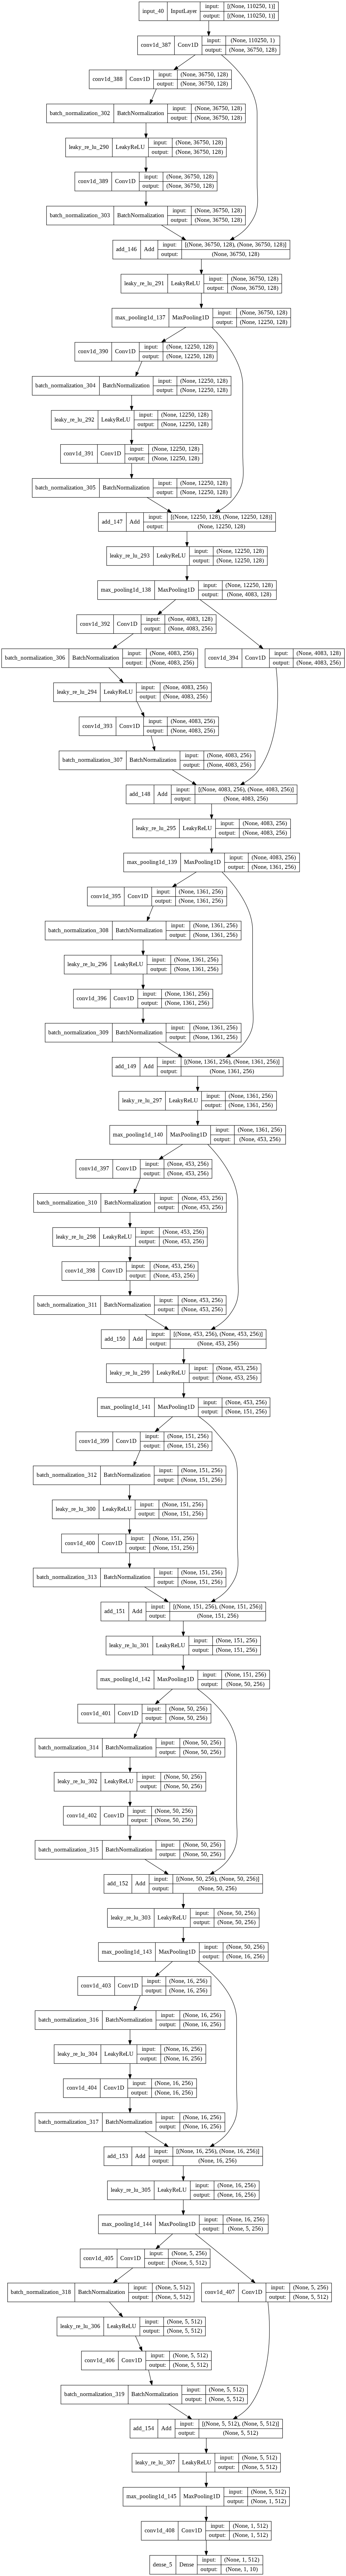

In [87]:
model = classifier()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

plot_model(model, show_shapes=True)